# Physics 494/594
## Training Neural Networks: Exercise

In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s.set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Last Time

### [Notebook Link: 16_Training_Neural_Network.ipynb](./16_Training_Neural_Network.ipynb)

- Combine feed forward with backpropagation for supervised learning
- Training our deep neural network to *learn* a 2D shape

## Today

- Team programming Exercise: the modified `XOR` function

<div class="span alert alert-success">
    <h3>1. Define a function that is a modified version of the <code>XOR</code> you studied on the homework:</h3>
    
\begin{equation}
    \mathtt{XOR}(x,y) = 
    \begin{cases}
    1 & (x \ge 0 \; \land \;  y < 0) \; \lor \;  (x < 0 \; \land \; y \ge 0) \\
    0 & \text{otherwise}
    \end{cases}
\end{equation}
</div>

In [2]:
def XOR(x,y):
    return (x>=0)*(y<0)+(x<0)*(y>=0)

<div class="span alert alert-success">
    <h3> 2. Plot the function on a grid of at least $41 \times 41$ points over a domain of your choice. </h3>
</div>

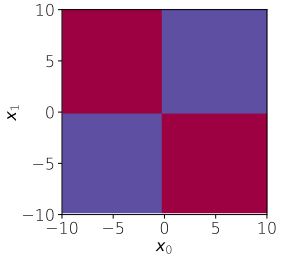

In [11]:
grid_size = 41

# The domain over which you want to plot [xmin,xmax,ymin,ymax]
extent = [-10.0, 10.0, -10.0, 10.0]

X = np.meshgrid(np.linspace(extent[0],extent[1],grid_size),np.linspace(extent[2],extent[3],grid_size))
batch_size = grid_size**2

aₒ = np.zeros([batch_size,2])
aₒ[:,0] = X[0].flatten()
aₒ[:,1] = X[1].flatten()

# Evaluate your function here
# note that *X unpacks the list (https://docs.python.org/3.7/tutorial/controlflow.html#unpacking-argument-lists)
result = XOR(*X)

plt.imshow(result,cmap='Spectral_r', rasterized=True, extent=extent,
           interpolation='nearest', origin='lower')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$');

<div class="span alert alert-success">
    <h3> 3. Use our backpropagation code (copied below) to train a neural network to find the weights and biases needed to reproduce the <code>XOR</code> function. </h3>
    
You can experiment with:
- non-linearity
- initial conditions
- batchsize 
- learning rate
- topology (number of layers and neurons) 
- learning algorithm

</div>

<div class="span alert alert-info">
    <h2>Incentive</h2>
    
Make sure to record you final cost.  The team that submits an excercise solution with the smallest cost will receive a prize of a 1-day extension on any remaining homework assignment to be used at a time of their choosing. 

For the case of a tie, the team with the simpler network topology will be the winner.
</div>

## Neural Network Training Code

I have copied and pasted this from [16_Training_Neural_Network.ipynb](./16_Training_Neural_Network.ipynb).

In [4]:
# -----------------------------------------------------------------------------------------
def feed_forward(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b).
       Return: activations (a) and derivatives f'(z).'''
    
    a,df = [aₒ],[]
    for wℓ,bℓ in zip(w,b):
        zℓ = np.dot(a[-1],wℓ) + bℓ
        _a,_df = ffprime(zℓ)
        a.append(_a)
        df.append(_df)
        
    return a,df

# -----------------------------------------------------------------------------------------
def backpropagation(y,a,w,b,df): 
    '''Inputs: results of a forward pass
       Targets     y: dim(y)  = batch_size ⨯ nL
       Activations a: dim(a)  = L ⨯ batch_size ⨯ nℓ
       Weights     w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases      b: dim(b)  = L-1 ⨯ nℓ
       f'(z)      df: dim(df) = L-1 ⨯ batch_size ⨯ nℓ
       
       Outputs: returns mini-batch averaged gradients of the cost function w.r.t. w and b
       dC_dw: dim(dC_dw) = dim(w)
       dC_db: dim(dC_db) = dim(b)
    '''
    
    num_layers = len(w)
    L = num_layers-1        
    batch_size = len(y)
    
    # initialize empty lists to store the derivatives of the cost functions
    dC_dw = [None]*num_layers
    dC_db = [None]*num_layers
    Δ = [None]*num_layers
    
    # perform the backpropagation
    for ℓ in range(L,-1,-1):
        
        # treat the last layer differently
        if ℓ == L:
            Δ[ℓ] = (a[ℓ] - y)*df[ℓ]
        else: 
            Δ[ℓ] = (Δ[ℓ+1] @ w[ℓ+1].T) * df[ℓ]
            
        dC_dw[ℓ] = (a[ℓ-1].T @ Δ[ℓ]) / batch_size
        dC_db[ℓ] = np.average(Δ[ℓ],axis=0)
        
    return dC_dw,dC_db

# -----------------------------------------------------------------------------------------
def gradient_step(η,w,b,dC_dw,dC_db):
    '''Update the weights and biases as per gradient descent.'''
    
    for ℓ in range(len(w)):
        w[ℓ] -= η*dC_dw[ℓ]
        b[ℓ] -= η*dC_db[ℓ]
    return w,b

# -----------------------------------------------------------------------------------------
def train_network(x,y,w,b,η):
    '''Train a deep neural network via feed forward and back propagation.
       Inputs:
       Input         x: dim(x) = batch_size ⨯ nₒ
       Target        y: dim(y) = batch_size ⨯ nL
       Weights       w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases        b: dim(b)  = L-1 ⨯ nℓ
       Learning rate η
       
       Outputs: the least squared cost between the network output and the targets.
       '''
    
    a,df = feed_forward(x,w,b)
    
    # we pass a cycled by 1 layer for ease of indexing (i.e. use a[-1] to get inputs)
    dC_dw,dC_db = backpropagation(y,a[1:]+[a[0]],w,b,df)
    
    w,b = gradient_step(η,w,b,dC_dw,dC_db)
    
    return 0.5*np.average((y-a[-1])**2)

# -----------------------------------------------------------------------------------------
def make_batch(n,batch_size,extent,func):
    '''Create a mini-batch from our inputs and outputs.
    Inputs:
    n0        : number of neurons in each layer
    batch_size: the desired number of samples in the mini-batch
    extent    : [min(xₒ),max(xₒ), min(x₁),max(x₁),…,min(x_{n[0]-1}),max(x_{n[0]-1})]
    func:     : the desired target function.
    
    Outputs: returns the desired mini-batch of inputs and targets.
    '''
    
    x = np.zeros([batch_size,n[0]])
    for i in range(n[0]):
        x[:,i] = np.random.uniform(low=extent[2*i],high=extent[2*i+1],size=[batch_size])

    # we expand the final axis such that y is a matrix (and not a vector)
    y = func(*[x[:,j] for j in range(n[0])])[:,np.newaxis]
    
    return x,y 

<div class="span alert alert-success">
    <h4> Initialize your network structure </h4>
</div>

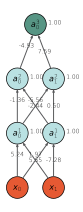

In [273]:
n = [2,2,2,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-10,high=10,size=(n[ℓ],n[ℓ+1])))
    b.append((np.random.uniform(low=1,high=1, size=n[ℓ+1])))
ml4s.draw_network(n, weights=w, biases=b)

<div class="span alert alert-success">
    <h4>Define a non-linearity</h4>
</div>

In [157]:
def ffprime(z): 
    '''calculate f(z) and f'(z).'''
    _f = 1.0/(1.0+np.exp(-z))#we'll use sigmoid for no particular reason
    return _f,np.exp(-z)*(_f**2)

<div class="span alert alert-success">
    <h4>Train your deep neural network </h4>
</div>

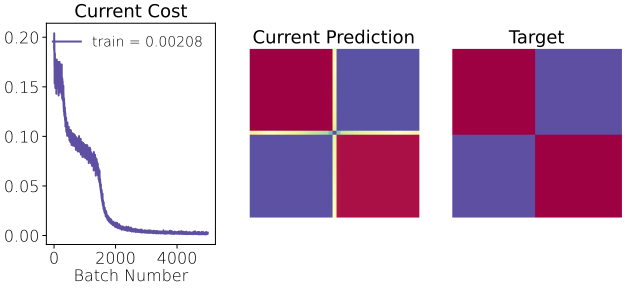

In [274]:
η = 0.9

batch_size = 500
num_steps = 5000

plot_ratio = int(num_steps / 50)
costs = np.zeros(num_steps)

# perform the training
for j in range(num_steps):
    
    x,y = make_batch(n,batch_size,extent,XOR)
    costs[j] = train_network(x,y,w,b,η)
    
    # we plot every plot_ratio steps
    if not j % plot_ratio or j == num_steps-1:
        a,df = feed_forward(aₒ,w,b)
        aL = a[-1].reshape(X[0].shape)
        
        fig,ax = ml4s.plot_training_2D(aL,XOR(*X),costs) 

<div class="span alert alert-success">
    <h4>List the names of your team members and print out your final score </h4>
</div>

In [275]:
team_members = ["Daniel Adunas"]
print(f'final cost = {np.average(costs[-10:]):.6E}')

final cost = 2.077743E-03
